<a id='00-nb'></a>

# Architect and Build a Music Recommender System across the Entire ML-Lifecycle with Amazon SageMaker

## Overview

----

Welcome of the Music Recommender use-case with Amazon SageMaker. In this series of notebooks we will go through the ML Lifecycle and show how we can build a Music Recommender System using a combination of SageMaker Services and features. IN each phase, we will have relevant notebooks that show you how easy it is to implement that phase of the lifecycle.


----

### Contents

- [Overview](00_overview_arch_data.ipynb)
    - [Architecture](#arch-overview)
    - [Get the Data](#get-the-data)
    - [Update the data sources](#update-data-sources)
    - [Explore the Data](#explore-data)
- [Part 1: Data Prep using SageMaker Processing Job](01_music_rec_data_prep.ipynb)
- [Part 2: Model Training and Hyperparameter Tuning](02_music_rec_model_training.ipynb)
- [Part 3: SageMaker Pipelines](03_music_rec_pipelines.ipynb)


<a id ='arch-overview'></a>

## Architecture

Let's look at the overall solution architecure for this use case. We will start by doing each of these tasks within the exploratory phase of the ML Lifecycle, then when we are done with Experimentation and Trials, we can develop an automated pipeline such as the one depicted here to prepare data, train and tune the model, deposit it in the registry, then deploy it to a SageMaker hosted endpoint, and run batch transform based on the trained model.

##### [back to top](#00-nb)

----

![Solution Architecure](./images/sagemaker_workshop_music.png)

In [2]:
import sys
import pprint
sys.path.insert(1, './code')


In [3]:
# update pandas to avoid data type issues in older 1.0 version
!pip install pandas --upgrade --quiet
import pandas as pd
print(pd.__version__)

1.3.5


In [4]:
# create data folder
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import sagemaker 
import boto3
import os
from awscli.customizations.s3.utils import split_s3_bucket_key

# Sagemaker session
sess = sagemaker.Session()
# get session bucket name
bucket = sess.default_bucket()
# bucket prefix or the subfolder for everything we produce
prefix='music-recommendation-workshop'
# s3 client
s3_client = boto3.client("s3")

print(f"this is your default SageMaker Studio bucket name: {bucket}")  

this is your default SageMaker Studio bucket name: sagemaker-us-east-1-631450739534


In [10]:
def get_data(public_s3_data, to_bucket, sample_data=1):
    new_paths = []
    for f in public_s3_data:
        bucket_name, key_name = split_s3_bucket_key(f)
        filename = f.split('/')[-1]
        new_path = "s3://{}/{}/input/{}".format(to_bucket, prefix, filename)
        new_paths.append(new_path)
        
        # only download if not already downloaded
        if not os.path.exists('./data/{}'.format(filename)):
            # download s3 data
            print("Downloading file from {}".format(f))
            s3_client.download_file(bucket_name, key_name, './data/{}'.format(filename))
    
        # subsample the data to create a smaller datatset for this demo
        new_df = pd.read_csv('./data/{}'.format(filename))
        new_df = new_df.sample(frac=sample_data)
        new_df.to_csv('./data/{}'.format(filename), index=False)
        
        # upload s3 data to our default s3 bucket for SageMaker Studio
        print("Uploading {} to {}\n".format(filename, new_path))
        s3_client.upload_file('./data/{}'.format(filename), to_bucket, os.path.join(prefix, 'input', filename))
        
    return new_paths


        

def update_data_sources(flow_path, tracks_data_source, ratings_data_source):
    with open(flow_path) as flowf:
        flow = json.load(flowf)
        
    for node in flow['nodes']:
        # if the key exists for our s3 endpoint
        try:
            if node['parameters']['dataset_definition']['name'] == 'tracks.csv':
                # reset the s3 data source for tracks data
                old_source = node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri']
                print("Changed {} to {}".format(old_source, tracks_data_source))
                node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri'] = tracks_data_source
            elif node['parameters']['dataset_definition']['name'] == 'ratings.csv':
                # reset the s3 data source for ratings data
                old_source = node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri']
                print("Changed {} to {}".format(old_source, ratings_data_source))
                node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri'] = ratings_data_source
        except:
            continue
    # write out the updated json flow file
    with open(flow_path, 'w') as outfile:
        json.dump(flow, outfile)
    
    return flow

<a id='get-the-data'></a>

## Prereqs: Get Data 

##### [back to top](#00-nb)

----

Here we will download the music data from a public S3 bucket that we'll be using for this demo and uploads it to your default S3 bucket that was created for you when you initially created a SageMaker Studio workspace. 

In [11]:
# public S3 bucket that contains our music data
s3_bucket_music_data = "s3://sagemaker-sample-files/datasets/tabular/synthetic-music"

In [12]:
new_data_paths = get_data([f"{s3_bucket_music_data}/tracks.csv", f"{s3_bucket_music_data}/ratings.csv"], bucket, sample_data=0.70)
print(new_data_paths)

Uploading tracks.csv to s3://sagemaker-us-east-1-631450739534/music-recommendation-workshop/input/tracks.csv

Uploading ratings.csv to s3://sagemaker-us-east-1-631450739534/music-recommendation-workshop/input/ratings.csv

['s3://sagemaker-us-east-1-631450739534/music-recommendation-workshop/input/tracks.csv', 's3://sagemaker-us-east-1-631450739534/music-recommendation-workshop/input/ratings.csv']


In [13]:
# these are the new file paths located on your SageMaker Studio default s3 storage bucket
tracks_data_source = f's3://{bucket}/{prefix}/input/tracks.csv'
ratings_data_source = f's3://{bucket}/{prefix}/input/ratings.csv'


<a id='explore-data'></a>

## Explore the Data


##### [back to top](#00-nb)


----

In [14]:
tracks = pd.read_csv('./data/tracks.csv')
ratings = pd.read_csv('./data/ratings.csv')

In [15]:
tracks.head()

,trackId,length,energy,acousticness,valence,speechiness,instrumentalness,liveness,tempo,genre
0,1395bf02-67b0-463d-82c9-b1a0a03327b9,206.0,0.503294,0.655674,0.430004,0.051380,0.000000,0.328493,125.178418,Jazz
1,a4aeb5f0-efac-414d-ab39-b7b8666c58fb,359.0,0.000020,0.996000,0.335748,0.022800,0.794613,0.178673,87.853502,Country
2,58167dd7-de2a-41c4-895b-4a5bcddd75b3,210.0,0.797469,0.408571,0.912363,0.022800,0.000000,0.104140,123.918778,Electronic
3,1a06ca78-7fd9-4543-80b5-a511ebf63d07,203.0,0.295750,0.907671,0.104288,0.022800,0.000000,0.087060,166.004655,Reggae
4,c0a43495-2f04-4d70-8a08-753455f0395f,232.0,0.987485,0.140653,0.671219,0.066709,0.342827,0.045223,94.165032,Electronic


In [16]:
ratings.head()

,ratingEventId,ts,userId,trackId,sessionId,itemInSession,Rating
0,f6c6430c-9685-45ac-a167-19dacd60c1d5,1587424177,11167,76c9db42-8349-4a9a-ac38-b16fdb57a693,9696,135,5.0
1,6bf23d5d-6d02-4464-ab1d-7c7bbdfeb786,1585845530,11202,1e85d8e1-b3e5-4e80-9bb6-962d9a8813ae,9330,5,3.0
2,f344998b-1778-4798-bd10-3b80e00754ec,1582941616,11199,afbd3ac5-9cbb-417a-ba82-7b95299ababe,7833,85,4.0
3,c8dba923-f879-42f6-82ff-f06c5c74f95c,1587683216,11121,7ed2dca5-da67-4e37-a936-db7fb44bd687,10219,134,5.0
4,7310ba85-633f-48a7-9721-d5ee5feb7879,1582030860,11013,c8d00198-f85c-47bf-b665-4882dbb6116a,7397,51,3.0


In [17]:
print("{:,} different songs/tracks".format(tracks['trackId'].nunique()))
print("{:,} users".format(ratings['userId'].nunique()))
print("{:,} user rating events".format(ratings['ratingEventId'].nunique()))

23,703 different songs/tracks
258 users
117,649 user rating events


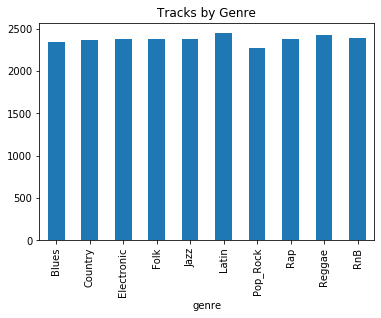

In [18]:
tracks.groupby('genre')['genre'].count().plot.bar(title="Tracks by Genre");

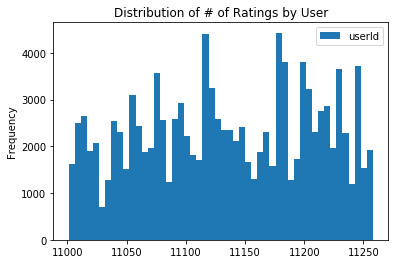

In [19]:
ratings[['ratingEventId','userId']].plot.hist(by='userId', bins=50, title="Distribution of # of Ratings by User");

----

# Music Recommender Lab 1: Data Prep using SageMaker Processing

After you completed running this notebook, you can open the next notebook.